In [1]:
import time
start = time.time()

In [2]:
#IMPORTS
from datetime import datetime
from pyspark.ml.fpm import PrefixSpan
from pyspark.sql import Row
import pyspark.sql.functions as F
from math import sin, cos, sqrt, atan2, radians 
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import operator


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
#FILES
inputPath  = "dataset_nearest_interpolation.csv" 
STATION_PATH="/data/students/bigdata-01QYD/Lab7/stations.csv"
#save file of first filter
output_file='results_1000_0.txt'
output_file2='results_1000_0_QuasiPiena_Piena.txt'
output_file3='results_1000_0_diff_delta.txt'
img_support='3-4-1000-0.jpg'
support=0

In [4]:
inputDF = spark.read.format("csv")\
.option("delimiter", ",")\
.option("header", True)\
.option("inferSchema", True).load(inputPath)

In [5]:
inputDF=inputDF.filter("used_slots is not null")

In [6]:
#parameters
interval=30 #time window
maxDelta=3 #how many delta
th=1 #distance
window_size=4 #window size

In [7]:
#filter for these fields
filteredDF = inputDF.filter("free_slots<>0 OR used_slots<>0")

In [8]:
#determine if the station is full, empty or partially full
def stateFunction(free_slots,used_slots):
    if free_slots==0:
        return 1
    elif (free_slots==1 or free_slots==2):
        return 0
    else:
        return 2

In [9]:
spark.udf.register("state", stateFunction)

<function __main__.stateFunction(free_slots, used_slots)>

In [10]:
def getInt(station):
    return (station)

In [11]:
spark.udf.register("intValue", getInt)

<function __main__.getInt(station)>

In [12]:
getStatusDF = filteredDF.selectExpr("station","timestamp", "state(free_slots,used_slots) as status")

In [13]:
#getStatusDF.show(100,False)

In [14]:
#filter only empty or full stations
full_empty=getStatusDF.filter("status==1 or status==0")

In [15]:
full_empty.count()

2074101

In [16]:
full_empty.count()/getStatusDF.count()*100

12.44198099085055

In [17]:
full_empty.describe().show()

+-------+------------------+-------------------+
|summary|           station|             status|
+-------+------------------+-------------------+
|  count|           2074101|            2074101|
|   mean|107.01611059442139| 0.3467420342596624|
| stddev| 71.69940973185341|0.47593287882526875|
|    min|               1.0|                  0|
|    max|             283.0|                  1|
+-------+------------------+-------------------+



In [18]:
#create a view
full_empty.createOrReplaceTempView("readings")

In [19]:
#select station, year, month, day, hour, minute, status ordered by time
ss=spark.sql("""SELECT  station , YEAR(timestamp) as year, MONTH(timestamp) as month, DAY(timestamp) as day, HOUR(timestamp)as hour, MINUTE(timestamp) as minute, status
FROM readings
GROUP BY station, year, month, day,hour,minute, status
ORDER BY  station,year, month,day, hour,minute
""")

In [20]:
##SHOW STATISTICS

In [21]:
info_st=ss.groupby("station")
stat_st=info_st.agg({"status":"count"})

In [22]:
info_stations=[]
info_counts=[]
info_stations.append(stat_st.rdd.map(tuple).map(lambda line: str(line[0])).collect())
info_counts.append(stat_st.rdd.map(tuple).map(lambda line: line[1]).collect())

In [23]:
#info_counts

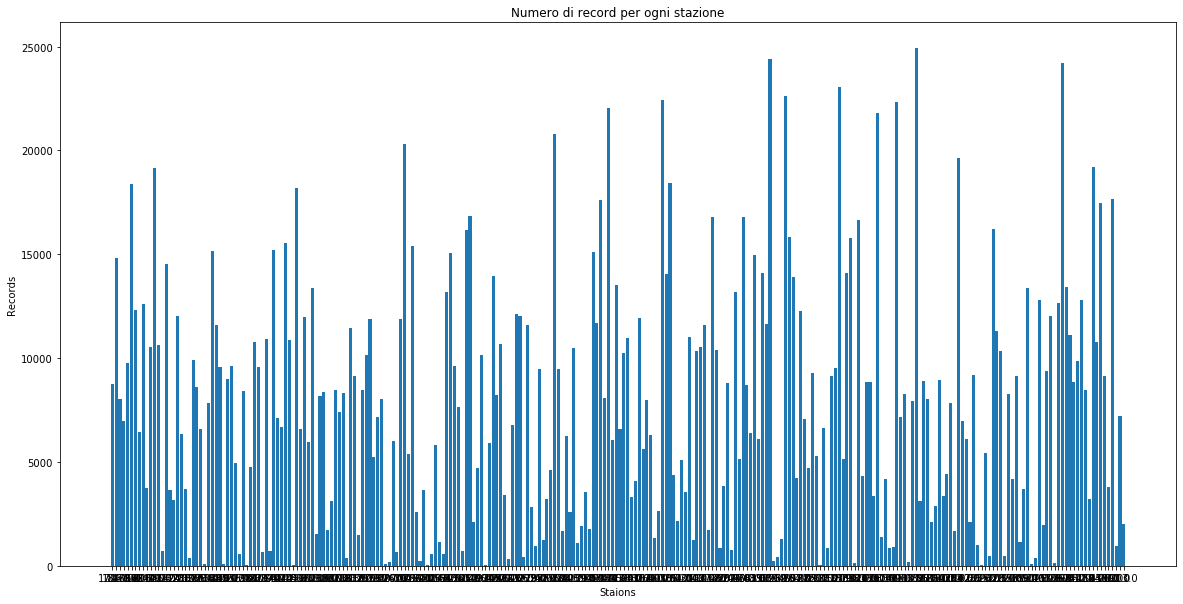

In [24]:
plt.figure(figsize =(20, 10))  
plt.bar(info_stations[0],info_counts[0])
plt.xlabel('Staions') 
plt.ylabel('Records') 
_=plt.title('Numero di record per ogni stazione')

In [25]:
sa=ss.groupby("station","year",'month', "status")
stat=sa.agg({"status": "count"})
stat=stat.sort("station","year","month","status")

In [26]:
window1=stat[stat.station==1]
window1=window1[stat.status==0]
window2=stat[stat.station==1]
window2=window2[stat.status==1]

window3=stat[stat.station==2 ]
window3=window3[stat.status==0]
window4=stat[stat.station==2]
window4=window4[stat.status==1]

window5=stat[stat.station==3 ]
window5=window5[stat.status==0]
window6=stat[stat.station==3]
window6=window6[stat.status==1]

window7=stat[stat.station==4 ]
window7=window7[stat.status==0]
window8=stat[stat.station==4]
window8=window8[stat.status==1]

window9=stat[stat.station==5 ]
window9=window9[stat.status==0]
window10=stat[stat.station==5]
window10=window10[stat.status==1]

In [27]:
stations=[]
month=[]
status=[]
counter=[]
for el in [window1, window2, window3, window4, window5, window6, window7, window8, window9, window10]:
    stations.append(el.rdd.map(tuple).map(lambda line: line[0]).collect())
    month.append(el.rdd.map(tuple).map(lambda line: str(line[2])).collect())
    status.append(el.rdd.map(tuple).map(lambda line: line[3]).collect())
    counter.append(el.rdd.map(tuple).map(lambda line: line[4]).collect())

In [28]:
counter

[[719, 2219, 1278, 3114],
 [503, 1083, 1419, 1551],
 [491, 1275, 1170, 1192],
 [407, 888, 751, 882],
 [1011, 1014, 1575, 4615],
 [267, 136, 1415, 1599],
 [759, 1905, 2731, 4150],
 [448, 1219, 1195, 1544],
 [79, 540, 1383, 3959],
 [33, 348, 278, 2527]]

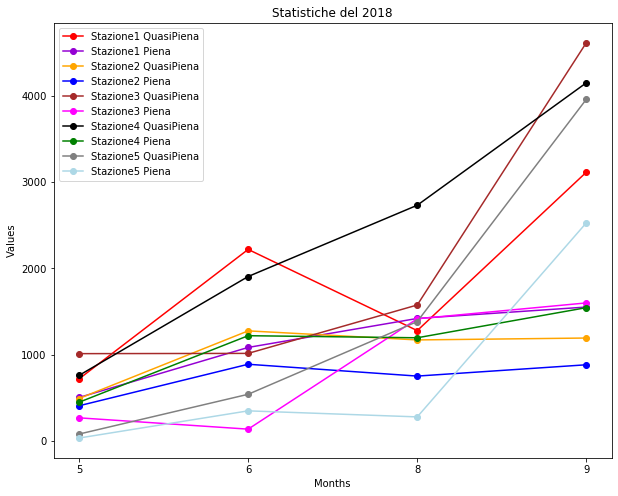

In [29]:
plt.figure(figsize =(10, 8))
colors=['red','darkviolet','orange','blue','brown','magenta','black','green','gray','lightblue']
for el in range(len(stations)):
    plt.plot(month[el],counter[el], marker = 'o',color=colors[el]) 
    plt.xlabel('Months') 
    plt.ylabel('Values')
    plt.legend(['Stazione1 QuasiPiena','Stazione1 Piena','Stazione2 QuasiPiena','Stazione2 Piena','Stazione3 QuasiPiena','Stazione3 Piena','Stazione4 QuasiPiena','Stazione4 Piena','Stazione5 QuasiPiena','Stazione5 Piena'])
_._=plt.title('Statistiche del 2018')

In [30]:
#create rdd and group into interval
my_rdd=ss.rdd.map(tuple)
rdd=my_rdd.map(lambda line: (line[0],line[1],line[2], line[3], line[4], int(line[5]/interval), line[6])).distinct()
#rdd.collect()

In [31]:
#get distinct stations to calculate distances
id_stations=rdd.map(lambda line: line[0]).distinct()

In [32]:
tot_id_stations=id_stations.collect()

In [33]:
#obtain timestamp and info
def getMap2(line):
    id_station=str(line[0])
    year=int(line[1])
    month=int(line[2])
    day=int(line[3])
    hour=int(line[4])
    minute=int(line[5])   
    timestamp= datetime(year,month, day, hour, minute)  
    status=int(line[6])
#     if status==0:
#         status='QuasiPiena'
#     else:
#         status='Piena'
    #info=id_station.split('.')[0]+'_'+status
    info=str(id_station)+' '+str(status)
    return (timestamp, info)

In [34]:
get_map2=rdd.map(getMap2)

In [35]:
#get_map2.collect()
#[(datetime.datetime(2008, 9, 4, 16, 1), '9.0', 1),

In [36]:
reduceK2=get_map2.reduceByKey(lambda l1,l2 :(l1+','+l2)).sortByKey()

In [37]:
#reduceK2.collect()

In [38]:
list_tot=reduceK2.collect()
# [(datetime.datetime(2008, 5, 15, 10, 0),
#   '53.0 0,55.0 

In [1]:
#list_tot[:5]

In [40]:
#list_tot[1]

In [41]:
voc_status={}
voc_timestamp={}
list_filtered=[]

voc_tmp={}

# previous_list=[]
# updated_list=[]

for i, el in enumerate(list_tot):
    #updated_list=[]    
    information=el[1]   
    tmp_list_station='' 
    voc_tmp={}
    
    for info in information.split(','):
        
        #print(info)
        station=str(info.split(' ')[0].split('.')[0])
            
        status=int(info.split(' ')[1])
        if  station not in voc_status:
            voc_status[station]=status
            voc_timestamp[station]=el[0]
            stringa=''
            if status==0:
                stringa='QuasiPiena'
            else:
                stringa='Piena'
            tmp_list_station+=','+station+'_'+ stringa 
            #updated_list.append(station)
                  
        else:
            times=voc_timestamp[station]
            actual_time=el[0]
            if times== actual_time:

                if status != voc_status[station] and voc_status[station]!=3:                    
                    voc_status[station]=3 
                    stringa=''
                    if status==0:
                        stringa='QuasiPiena'
                    else:
                        stringa='Piena'
                    tmp_list_station+=','+station+'_'+ stringa 
                    
            else:            
                # after 30 minutes
                if (actual_time.minute-times.minute)==1:
                    if voc_status[station]==3:                     
                        voc_status[station]=status
                        voc_timestamp[station]=actual_time
                        stringa=''
                        if status==0:
                            stringa='QuasiPiena'
                        else:
                            stringa='Piena'
                        tmp_list_station+=','+station+'_'+ stringa 
                        #updated_list.append(station)
                        
                    elif voc_status[station]==1 and status==0:                        
                        voc_status[station]=0
                        voc_timestamp[station]=actual_time
                        stringa=''
                        if status==0:
                            stringa='QuasiPiena'
                        else:
                            stringa='Piena'
                        tmp_list_station+=','+station+'_'+ stringa 
                        
                        if station in voc_tmp:
                            if voc_tmp[station]==1:
                                 tmp_list_station+=','+station+'_Piena'
#                         tmp_check=station+'_Piena'
#                         if tmp_check not in tmp_list_station:
#                             tmp_list_station+=','+station+'_Piena' 
                        #updated_list.append(station)                      
                        
                    elif voc_status[station]==0 and status==1:
                        voc_status[station]=1
                        voc_timestamp[station]=actual_time
                        stringa=''
                        if status==0:
                            stringa='QuasiPiena'
                        else:
                            stringa='Piena'
                        tmp_list_station+=','+station+'_'+ stringa
                        
                        if station in voc_tmp:
                            if voc_tmp[station]==0:
                                 tmp_list_station+=','+station+'_QuasiPiena'
                        
#                         tmp_check=station+'_QuasiPiena'
#                         if tmp_check in not in tmp_list_station:
#                             tmp_list_station+=','+station+'_QuasiPiena'
                            #updated_list.append(station)
                        
                        
                    elif  voc_status[station]==0 and status==0:
                        voc_tmp[station]=0
                    elif  voc_status[station]==1 and status==1:
                        voc_tmp[station]=1
                    
                # after more than 30 minutes        
                elif (actual_time.minute-times.minute)>1:
                    voc_status[station]==''
                    voc_timestamp[station]=''
           
        
#     if i!=0:
#         #previous_list=set(previous_list)
#         updated_list=set(updated_list)

#         for st in previous_list:
#             if st not in updated_list:              
#                 voc_status.pop(st)  
#                 voc_timestamp.pop(st)
                
            
#     previous_list=updated_list
#     updated_list=[]
    
    list_filtered.append((el[0],tmp_list_station[1::]))

In [42]:
reduceK=spark.sparkContext.parallelize(list_filtered)
#reduceK.collect()

In [43]:
#reduceK.collect()

In [44]:
my_df=reduceK.toDF()
#my_df.collect()

In [45]:
my_df.createOrReplaceTempView("view")

In [46]:
s2=spark.sql("""SELECT ROW_NUMBER() OVER(ORDER BY _1,_2) as id ,_1, _2
FROM view """)

In [47]:
#identifier of the timestamp, info
rdd_scheme=s2.rdd.map(tuple).map(lambda line: (line[0], line[2]))
#rdd_scheme.collect()
#(1,  '59_QuasiPiena,16_QuasiPiena,61_Piena,135_QuasiPiena,62_Piena,45_Piena,14_QuasiPiena,65_QuasiPiena,61_QuasiPiena,40_QuasiPiena,9_QuasiPiena,53_QuasiPiena,69_QuasiPiena,71_QuasiPiena,56_QuasiPiena,10_QuasiPiena,62_QuasiPiena,132_QuasiPiena,55_QuasiPiena,119_QuasiPiena,12_QuasiPiena,252_QuasiPiena,71_Piena,131_QuasiPiena,59_Piena'),

In [48]:
#rdd_scheme.collect()

In [49]:
#obtain window, station-status
def giveSplit(line):   
    id_window=( int(line[0] ))
    lista=[]    
    counter=id_window    
    while counter>=1:
        lista.append(('Window '+str(counter),(line[1])))
        counter=counter-1
        if (id_window-counter)==window_size:
            return lista  
    return lista

In [50]:
mapData=rdd_scheme.flatMap(giveSplit)
#mapData.collect()

In [51]:
filteredD=mapData.filter(lambda line: line[1]!='')
#filteredD.collect()

In [52]:
# for each window get all info
all_keys=filteredD.reduceByKey(lambda l1,l2:(l1+'-'+l2))

In [53]:
#all_keys.collect()

In [54]:
#finestra temporale
def reduceKeys(line):   
    lista=[]
    #lista.append(line[0])
    line_split=line[1].split("-")
    #return line_split[0]
    count=len(line_split)
    tot=[]
    for val in range(count):
        li=[]
        stations=line_split[val].split(',')
        for st in stations:
            all_string_st=st.split('_')[0]+'_'+'T'+str(val)+'_'+st.split('_')[1]
            li.append(all_string_st)
        tot.append(li)
    lista.append((line[0],(tot))) 
    return lista

In [55]:
windows=all_keys.flatMap(reduceKeys)

In [56]:
#windows.collect()
#[('Window 1',
#   [['62.0_T0_Piena',
#     '40.0_T0_Piena',

In [57]:
#save station file
stationsDF = spark.read.format("csv")\
.option("delimiter", "\\t")\
.option("header", True)\
.option("inferSchema", True).load(STATION_PATH)

In [58]:
#get only rows interested: only the used stations 
necessary_rows=stationsDF.filter(F.col("id").isin(tot_id_stations)).rdd.map(tuple)

In [59]:
#necessary_rows.collect()

In [60]:
#get info of stations about coordinates and name
coordinates=necessary_rows.map(lambda line: (line[0],(str(line[1])+'-'+str(line[2]))))
names_stations=necessary_rows.map(lambda line: (line[0],line[3]))

In [61]:
list_coo=coordinates.collect()
#list_coo

In [62]:
#create a dictionary in which the key is the station and value is the info about coordinates
dic_co=coordinates.collectAsMap()
dic_coordinates=sc.broadcast(dic_co)
#dic_coordinates.value[1]

In [63]:
#function to retrieve distance between 2 stations
def getDistance(station1,station2):
    # approximate radius of earth in km
    R = 6373.0    
    lat_a=float(station1.split('-')[0])
    lat_b=float(station2.split('-')[0])
    long_a=float(station1.split('-')[1])
    long_b=float(station2.split('-')[1])
    
    lat1=radians(lat_a)
    lat2=radians(lat_b)
    lon1=radians(long_a)
    lon2=radians(long_b)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [64]:
#voc in which the key is a pair of stations and value is the distance
voc_distances={}
for i in range(len(list_coo)):
    for j in range(i+1,len(list_coo)):
        station1=list_coo[i][0]
        station2=list_coo[j][0]
        d_i=list_coo[i][1]
        d_j=list_coo[j][1]
        distance=getDistance(d_i,d_j)
        id_stations=str(station1)+' '+str(station2)
        voc_distances[id_stations]=distance

In [65]:
#voc_distances['47 271']

In [66]:
#voc_distances

In [67]:
# average distance between stations
avg_distance=0
for dist in voc_distances.values():
    avg_distance+=dist
avg_distance=avg_distance/len(voc_distances)
#avg_distance

In [68]:
avg_distance_float=float("{:.2f}".format(avg_distance))
print(f'The average distance is {avg_distance_float} Km')

The average distance is 4.07 Km


In [69]:
set_all_stations=set()
for key in voc_distances:
    first_el=int(key.split(' ')[0])
    second_el=int(key.split(' ')[1])
    set_all_stations.add(first_el)
    set_all_stations.add(second_el)

In [70]:
# all stations that are at a distance smaller or equal to 1 km from station 1 as reference
list_stations=[]
count_stations=0
reference_station=2

for key in voc_distances:
    first_el=int(key.split(' ')[0])
    second_el=int(key.split(' ')[1])
    if first_el==reference_station and voc_distances[key]<=1: 
        count_stations+=1
        list_stations.append(second_el)       
    elif second_el==reference_station and voc_distances[key]<=1:
        count_stations+=1
        list_stations.append(first_el)

In [71]:
for distance in [0.5,1,2,3,4,5]:
    sum_stations=0
    for reference_station in list(set_all_stations):
    #     list_stations=[]
        count_stations=0    
        for key in voc_distances:
            first_el=int(key.split(' ')[0])
            second_el=int(key.split(' ')[1])
            if first_el==reference_station and voc_distances[key]<=distance: 
                count_stations+=1
    #             list_stations.append(second_el)       
            elif second_el==reference_station and voc_distances[key]<=distance:
                count_stations+=1
    #             list_stations.append(first_el)
        sum_stations+=count_stations  
    num_stations_Km=float("{:.2f}".format(sum_stations/len(list(set_all_stations))))
    print(f'The average number of stations that are at a distance smaller or equal than {distance} Km is {num_stations_Km}')

The average number of stations that are at a distance smaller or equal than 0.5 Km is 3.51
The average number of stations that are at a distance smaller or equal than 1 Km is 14.32
The average number of stations that are at a distance smaller or equal than 2 Km is 49.84
The average number of stations that are at a distance smaller or equal than 3 Km is 94.91
The average number of stations that are at a distance smaller or equal than 4 Km is 140.07
The average number of stations that are at a distance smaller or equal than 5 Km is 179.53


In [72]:
#Applicazione “Delta Spaziale”
def giveSpatialWindow(line):
    lista=[]    
    time0=line[1][0]    
    dic={}
    
    count_windows=len(line[1])#tot windows

    for station in time0:# only first window
        act_station=int(station.split('_')[0])
        #lista_station=[] 
        list_tmp=[]
        
        #for each window
        for i,window in enumerate(line[1]):           
            second_lista=[]
            #for each element of a window
            for all_el in window :
                #second_lista=[]
                act_all_el=int(all_el.split('_')[0])
                state=all_el.split('_')[2]
               
                if act_station!=act_all_el:
                    
                    key=''
                    if act_station<act_all_el:
                        key=str(act_station)+' '+str(act_all_el)
                    else:
                        key=str(act_all_el)+' '+str(act_station)                    
                    
                    dist=voc_distances[key]
                    if dist<=maxDelta*th:
                        delta=0
                        for d in range(1,maxDelta+1):
                            if d*th>=dist:
                                delta=d
                                break                        
                        string=state+'_'+'T'+str(i)+'_'+str(delta)
                        second_lista.append(string)
                else:
                    string=state+'_'+'T'+str(i)+'_'+str(0)
                    second_lista.append(string)
                    
            if len(second_lista)>0:
                list_tmp.append(second_lista)
        lista.append(((line[0]+'|'+str(act_station)),list_tmp))
    
    return lista

In [73]:
spatial_app=windows.flatMap(giveSpatialWindow)

In [74]:
#spatial_app.collect()

In [75]:
def row_seq(line):
    true=line[1]
    string=Row(sequence=true)
    return string

In [76]:
spatial=spatial_app.map(row_seq)

In [77]:
#spatial.collect()

In [78]:
#create a dataframe
df=spatial.toDF()

In [79]:
supports=[support]

In [80]:
#df.show(20,False)

In [81]:
#prefixspan to obtain sequence and frequence
counter=[]
for support in supports:
    print(support)
    prefixSpan = PrefixSpan(minSupport=support, maxPatternLength=5,
                        maxLocalProjDBSize=5000)
    prefix=prefixSpan.findFrequentSequentialPatterns(df)   
    len_prefix=prefix.count()    
#     prefix.show(len_prefix,False)
#     counter.append(len_prefix)

0


In [82]:
len_prefix

132141

In [83]:
pre=prefix.rdd.map(tuple)

In [84]:
#pre.collect()

In [85]:
def giveSelected(line):
    seq=line[0]
    found=False   
    for window in seq:
        for el in window:
            if 'T0' in el and '_0' in el:
                found=True
                break
    return found 

In [86]:
giveT0=pre.filter(giveSelected)

In [87]:
#giveT0.collect()

In [88]:
df2=giveT0.toDF().withColumnRenamed('_1','sequence')
df2=df2.withColumnRenamed('_2','freq')#.show(len_prefix,False)

In [89]:
#df2.show()

In [90]:
def mapValues(line):
    seq=line[0]
    final=''
    #voc[seq]=line[1]
    for i,window in enumerate(seq):
        if i>0:
            final+='-'
        for j,el in enumerate(window):
            if j>0:
                final+=','
            final+=el
    final+=(';'+str(line[1])+';'+str(i))
    return final  

In [91]:
mapDict=giveT0.map(mapValues)

In [92]:
#mapDict.collect()

In [93]:
li=mapDict.collect()
voc={}

In [94]:
for el in li:
    splits=el.split(';')
    voc[splits[0]]=int(splits[1])

In [95]:
#voc

In [96]:
repeated_el_window=0
for el in voc.keys():
    flag_rep=False
    windows=el.split('-')
    for w in windows:
        tot_items=len(w.split(','))
        set_items=len(set(w.split(',')))
        if tot_items!=set_items:
            repeated_el_window+=1
            break
repeated_el_window

11518

In [97]:
voc_supports={}
for el in voc.keys():    
    if len(el.split('-'))>1:        
        num=int(voc[el])       
        string=''
        tot=el.split('-')[:-1]
        for k,station in enumerate(tot):
            if k>0:
                string+='-'
            string+=station
        #print(string)
        den=int(voc[string])
        voc_supports[el]=str(num/den)+'-'+str(voc[el])
keys=list(voc_supports.keys())
values=list(voc_supports.values())

In [98]:
#voc_supports

In [99]:
#sort vocabulary by decreasing values and sort within each window
tot_frequence=0
for key in voc_supports:    
    splitted=key.split('-')      
    splitted.sort()
    tmp_frequence=int(voc_supports[key].split('-')[1])
    tot_frequence+=tmp_frequence
for key in voc_supports:
    freq= int(voc_supports[key].split('-')[1])
    #print(freq)
    perc_value=float("{:.2f}".format(freq*100/tot_frequence))
    voc_supports[key]=str(voc_supports[key].split('-')[0])+'-' + str(freq)+'-'+str(perc_value)+'%'  
voc_supports = dict(sorted(voc_supports.items(), key=operator.itemgetter(1),reverse=True))

In [100]:
#voc_supports

In [101]:
file = open(output_file, "w")

In [102]:
list_pattern=[]

In [103]:
for el in voc_supports:
    key_list=[]
    for e in el.split('-'):
        key_list.append([e])
    list_pattern.append([[key_list], [voc_supports[el]]])

In [104]:
file.write('Pattern, Confidence-Frequence-Frequence %'+'\n')
for el in list_pattern:  
    file.write(str(el)+ '\n')    
file.close() 

In [105]:
# delete supp
for key in voc_supports:
    v=voc_supports[key].split('-')
    voc_supports[key]=v[0]+'-'+v[1]    

In [106]:
#voc_supports

In [107]:
tot_list=[]
for i, j in zip(keys,values):
    key_list=[]
    for el in i.split('-'):
        key_list.append([el])
    tot_list.append([[key_list], [j]])

In [108]:
confidence=[]
for el in values:
    #print(el.split('-')[0])
    val=round(float(el.split('-')[0]),2)
    confidence.append(val)
#confidence    

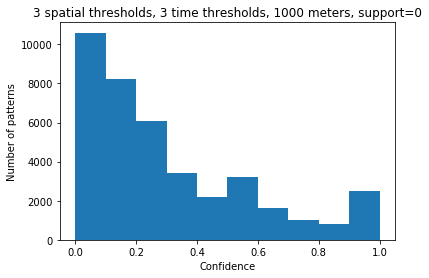

In [109]:
plt.hist(confidence)
plt.xlabel('Confidence')
plt.ylabel('Number of patterns')
plt.title('3 spatial thresholds, 3 time thresholds, 1000 meters, support=0')
plt.savefig(img_support)
plt.show()

In [110]:
#how many min, max, avg items there are
num_items=0
num_freq_items=0
min_items=sys.maxsize
max_items=0
avg_items=0

num_freq_window=0
tot_window=0
num_patterns=0
min_window=sys.maxsize
max_window=0
avg_window=0
flag_piena=False
flag_quasi_piena=False

list_piena_quasi_piena=[]

for key in voc_supports.keys():
    flag_piena=False
    flag_quasi_piena=False    
    string=''
    
    #statistics for the windows
    if '-' in key:
        patterns=len(key.split('-'))
        tot_window+=patterns      
    else:
        tot_window+=1
        patterns=1
    num_patterns+=1
    
    #statistics for the ìtems
    if ('-' in key and ',' in key):
        new_key=key       
        new_key=new_key.replace(',', '-')               
        items=new_key.split('-')
        for el in items:
            string+=el.split('_')[0]
            if el.split('_')[0].startswith('Piena') and flag_piena==False:
                flag_piena=True
            elif el.split('_')[0].startswith('QuasiPiena') and flag_quasi_piena==False:
                flag_quasi_piena=True
      
       
    elif ('-' in key):
        items=key.split('-')
        for el in items:
            string+=el.split('_')[0]
            if el.split('_')[0].startswith('Piena') and flag_piena==False:
                flag_piena=True
            elif el.split('_')[0].startswith('QuasiPiena') and flag_quasi_piena==False:
                flag_quasi_piena=True
       
    elif ( ',' in key):
        items=key.split(',')
        for el in items:
            string+=el.split('_')[0]
            if el.split('_')[0].startswith('Piena') and flag_piena==False:
                flag_piena=True
            elif el.split('_')[0].startswith('QuasiPiena') and flag_quasi_piena==False:
                flag_quasi_piena=True
      
    else:
        items=list(key)
        for el in items:
            string+=el.split('_')[0]
            if el.split('_')[0].startswith('Piena') and flag_piena==False:
                flag_piena=True
            elif el.split('_')[0].startswith('QuasiPiena') and flag_quasi_piena==False:
                flag_quasi_piena=True
    if (flag_quasi_piena==True and flag_piena==True):       
        #list_piena_quasi_piena.append([key])
        key_list=[]            
        for e in key.split('-'):
            key_list.append([e])
        list_piena_quasi_piena.append([[key_list], [voc_supports[key]]])

    q_items=len(items) 
    if min_items>q_items:
        min_items=q_items
    if max_items<q_items:
        max_items=q_items
    freq=int(voc_supports[key].split('-')[1])
    num_items+=freq 
    num_freq_items+=freq*q_items
    
    if min_window> patterns:
        min_window=patterns
    if max_window<patterns:
        max_window=patterns    
    num_freq_window+=freq*patterns  

avg_window=0
if num_items!=0:
    avg_items=float(num_freq_items)/float(num_items)    
    print(f'The average number of items is: {avg_items}')    
    avg_window=float(num_freq_window)/ float(num_items)
    print(f'The average number of windows is: {avg_window}')
else:
    print(f'The average number of windows is: {avg_window}')

if min_items>1000:
    min_items=0
    min_window=0
print(f'The minimum number of items is: {min_items}')
print(f'The maximum number of items is: {max_items}')
print(f'The minimum number of windows is: {min_window}')
print(f'The maximum number of windows is: {max_window}')

The average number of items is: 4.63209234869288
The average number of windows is: 2.749666870348148
The minimum number of items is: 2
The maximum number of items is: 5
The minimum number of windows is: 2
The maximum number of windows is: 4


In [111]:
print('FILTER PATTERNS WITH AT LEAST 1 EVENT QUASI PIENA AND 1 EVENT PIENA ')

FILTER PATTERNS WITH AT LEAST 1 EVENT QUASI PIENA AND 1 EVENT PIENA 


In [112]:
file2 = open(output_file2, "w")

In [113]:
lung_piena_quasipiena=0
if len(list_piena_quasi_piena)!=0:
    df_supports=sc.parallelize(list_piena_quasi_piena).toDF().withColumnRenamed('_1','sequence')
    df_supports=df_supports.withColumnRenamed('_2','confidence-freq')
    lung_piena_quasipiena=df_supports.count() 
#     df_supports.show(lung_piena_quasipiena,False)
#     print(lung_piena_quasipiena)

In [114]:
file2.write('Pattern, Confidence-Frequence-Frequence %'+'\n')

tot_frequence=0
if len(list_piena_quasi_piena)!=0:    
    for key in list_piena_quasi_piena:    
        #print(list_piena_quasi_piena[key])
        tmp_frequence=int(key[1][0].split('-')[1])
        tot_frequence+=tmp_frequence

if len(list_piena_quasi_piena)!=0:
    for el in list_piena_quasi_piena:
        perc=int(el[1][0].split('-')[1])
        perc_value=float("{:.2f}".format(perc*100/tot_frequence))
        c='['+str(el[0])+', ['+str(el[1][0])+'-'+str(perc_value)+'%]]'
        
        file2.write(c+'\n')
file2.close()

In [115]:
print('FILTER PATTERNS WITH AT LEAST 1 T0, DELTA S=0 AND AT LEAST 1 PATTERN WITH AT LEAST 1 PATTERN WITH DELTA S DIFFERENT FROM 0 AND DELTA T DIFFERENT FROM 0')

FILTER PATTERNS WITH AT LEAST 1 T0, DELTA S=0 AND AT LEAST 1 PATTERN WITH AT LEAST 1 PATTERN WITH DELTA S DIFFERENT FROM 0 AND DELTA T DIFFERENT FROM 0


In [116]:
list_influenze=[]
for el in voc_supports.keys():
    delta_spaziale=False
    if ('-' in el):
        all_windows_list=el.split('-')
        if ('T0_0' in all_windows_list[0] ):
            for cons_window in all_windows_list[1::]:
                if ',' in cons_window:
                    for item in cons_window.split(','):                       
                        act_delta=int(item.split('_')[2])
                        if act_delta!=0:
                            delta_spaziale=True
    if delta_spaziale==True:        
        key_list=[]            
        for e in el.split('-'):
            key_list.append([e])
        list_influenze.append([[key_list], [voc_supports[el]]])

In [117]:
file3 = open(output_file3, "w")

In [118]:
lung_different_time_space=0
if len(list_influenze)!=0:
    df_supports=sc.parallelize(list_influenze).toDF().withColumnRenamed('_1','sequence')
    df_supports=df_supports.withColumnRenamed('_2','confidence-freq')
    lung_different_time_space=df_supports.count() 
    #df_supports.show(lung_different_time_space,False)
    #print(lung_different_time_space)

In [119]:
file3.write('Pattern, Confidence-Frequence-Frequence %'+'\n')

tot_frequence=0
if len(list_influenze)!=0:    
    for key in list_influenze:    
        tmp_frequence=int(key[1][0].split('-')[1])
        tot_frequence+=tmp_frequence


if len(list_influenze)!=0:
    for el in list_influenze: 
        perc=int(el[1][0].split('-')[1])
        perc_value=float("{:.2f}".format(perc*100/tot_frequence))
        c='['+str(el[0])+', ['+str(el[1][0])+'-'+str(perc_value)+'%]]'
        
        file3.write(c+'\n')
        
file3.close()

In [120]:
print(f'The number of patterns in the pre-filter is: {len_prefix}')

The number of patterns in the pre-filter is: 132141


In [121]:
print(f'The number of items after the filter with at least 2 windows and at least a T0 and delta 0 is: {len(voc_supports)}')

The number of items after the filter with at least 2 windows and at least a T0 and delta 0 is: 39721


In [122]:
print('STATISTICS about sequences with at least 2 windows_T0_delta0')
print(f'The average number of windows is: {avg_window}')
print(f'The minimum number of windows is: {min_window}')
print(f'The maximum number of windows is: {max_window}')
print(f'The average number of items is: {avg_items}')
print(f'The minimum number of items is: {min_items}')
print(f'The maximum number of items is: {max_items}')

STATISTICS about sequences with at least 2 windows_T0_delta0
The average number of windows is: 2.749666870348148
The minimum number of windows is: 2
The maximum number of windows is: 4
The average number of items is: 4.63209234869288
The minimum number of items is: 2
The maximum number of items is: 5


In [123]:
print(f'The number of patterns in which there is at least one item that repeats within a window is: {repeated_el_window} ')

The number of patterns in which there is at least one item that repeats within a window is: 11518 


In [124]:
print(f'The number of patterns with at least 1 event QuasiPiena and 1 event Piena is: {lung_piena_quasipiena}')

The number of patterns with at least 1 event QuasiPiena and 1 event Piena is: 36765


In [125]:
 print(f'The number of patterns with at least 1 T0, DELTA S=0 and at least 1 pattern with at least 1 pattern with DELTA S different from 0 and DELTA T different from 0 is: {lung_different_time_space}')

The number of patterns with at least 1 T0, DELTA S=0 and at least 1 pattern with at least 1 pattern with DELTA S different from 0 and DELTA T different from 0 is: 26904


In [126]:
end = time.time()
print(f'The time of execution is: {end-start} s')

The time of execution is: 319.2218780517578 s
